<a href="https://www.kaggle.com/code/liviam/guassianmixturemodel-ach-reviews?scriptVersionId=101672251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-crossing/items.csv
/kaggle/input/animal-crossing/villagers.csv
/kaggle/input/animal-crossing/user_reviews.csv
/kaggle/input/animal-crossing/critic.csv


In [5]:
# Installations - Spacy Language Detector
!pip install spacy-langdetect

  Using cached spacy_langdetect-0.1.2-py3-none-any.whl (5.0 kB)
  Using cached langdetect-1.0.7-py3-none-any.whl


In [6]:
## IMPORTS - Additional to the ones above.

# Data handling
from collections import Counter
from sklearn.model_selection import train_test_split

# Text analytics
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# Date and time
from datetime import datetime

# Data visualization
from tabulate import tabulate
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis
import math as mth
import statistics
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.mixture import GaussianMixture


In [7]:
## DATA 

# Create reviews dataframes
reviews_df = pd.read_csv("../input/animal-crossing/user_reviews.csv") # User reviews data frame

## CHECK EACH DF
reviews_df.head(5)

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


# Summarizing the Data + Text Analysis
- Count of reviews
- Summary of grades
- Review size: word counts, character counts, size ranges


In [8]:
# Count of reviews
review_count = len(reviews_df.text)
F"There are {review_count} reviews for Animal Crossing."

'There are 2999 reviews for Animal Crossing.'

In [9]:
# Count of grades
grade_counts = len(reviews_df.grade)
F"There are {grade_counts} grades/ratings for Animal Crossing."

'There are 2999 grades/ratings for Animal Crossing.'

In [10]:
# GRADES SUMMARY
grades_summary_table = tabulate({"Calculation":["Max Rating", 
                                                "Min Rating", 
                                                "Mode"],
                                 "Value": [max(reviews_df.grade),
                                           min(reviews_df.grade),
                                           statistics.mode(reviews_df.grade)]},
                                headers = "keys", 
                                tablefmt = "fancy_grid")
print(grades_summary_table)

╒═══════════════╤═════════╕
│ Calculation   │   Value │
╞═══════════════╪═════════╡
│ Max Rating    │      10 │
├───────────────┼─────────┤
│ Min Rating    │       0 │
├───────────────┼─────────┤
│ Mode          │       0 │
╘═══════════════╧═════════╛


╒═════════╤══════════╕
│   Grade │   Counts │
╞═════════╪══════════╡
│       0 │     1158 │
├─────────┼──────────┤
│       1 │      255 │
├─────────┼──────────┤
│       2 │      131 │
├─────────┼──────────┤
│       3 │       98 │
├─────────┼──────────┤
│       4 │      105 │
├─────────┼──────────┤
│       5 │       78 │
├─────────┼──────────┤
│       6 │       44 │
├─────────┼──────────┤
│       7 │       34 │
├─────────┼──────────┤
│       8 │       91 │
├─────────┼──────────┤
│       9 │      253 │
├─────────┼──────────┤
│      10 │      752 │
╘═════════╧══════════╛


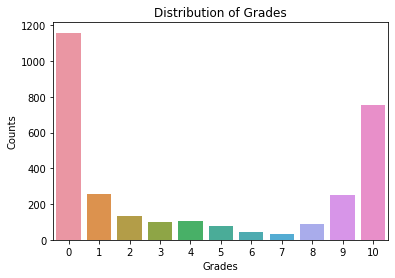

In [11]:
# Counts per grade
grades_counts = Counter(reviews_df.grade)
sorted_grades = sorted(grades_counts.items()) # List of tuples

# Values lists
x_vals = []
y_vals = []

# Iterate through the list of sorted grades
for idx, tuple in enumerate(sorted_grades):
    x_vals.append(tuple[0])
    y_vals.append(tuple[1])
    
# Tabular format
ah_grades = tabulate({"Grade": x_vals,
                     "Counts": y_vals},
                     headers = "keys",
                     tablefmt = "fancy_grid")

# Visualization
# Bar chart object
grade_bar = sns.barplot(x = x_vals, y = y_vals)
grade_bar.set(xlabel = "Grades", ylabel = "Counts", title="Distribution of Grades")

# Display the breakdown of grades
print(ah_grades)

In [12]:
# GROUPING OF GRADES - useful for when setting up for sentiment analysis and other text analytics.
grade_categories = {"negative": [0,1,2,3],
                    "neutral": [4,5,6],
                    "positive":[7,8,9,10]}

### Word Tokenization
In order to obtain accurate information about the reviews, it's necessary to tokenize the text content. SpaCy is excellent for this because of how powerful and easy to use it is. 


In [13]:
# Wrap language detector in a function
def get_lang_detector(nlp, name):
    return LanguageDetector()

# Initialize a spaCy pipeline nlp
nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

# Add a language detector via sentencizer
nlp.add_pipe('sentencizer') 

In [14]:
# Language 
lang_name = []

# Iterate through texts
for review in reviews_df.text:
    # Runs the language detector on the review
    doc = nlp(review)
    # Gets the language and the score
    if(doc._.language):
    # Puts the language into lang_name
        lang_name.append(doc._.language['language'])
    else:
        lang_name.append('unknown')
    
    

In [15]:
# Get counts of each language that appears
lang_counter = Counter(lang_name)
print(lang_counter)

# Put the language name in the dataframe
reviews_df['language'] = lang_name

Counter({'en': 2828, 'es': 108, 'fr': 18, 'pt': 11, 'ru': 11, 'it': 10, 'de': 4, 'so': 2, 'pl': 2, 'th': 1, 'no': 1, 'ko': 1, 'zh-cn': 1, 'fi': 1})


In [16]:
# Create a new dataframe with only English language reviews
eng_revs = reviews_df[reviews_df['language'] == 'en'].copy()

eng_revs.head(5)

,grade,user_name,text,date,language
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20,en
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20,en
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20,en


In [17]:
# Tokenizer
tokenizer = nlp.tokenizer # Will include punctuation in addition to vocabulary

# Texts to tokenize
texts = [text for text in eng_revs.text]

# Create a pipeline for the texts
text_tokens = list(tokenizer.pipe(texts, batch_size = 100))

# Examine a token
print(text_tokens[10])

they heavily marketed this game as a social experience. a game to share with your friends and family. but heres the catch, you will need 1 nintendo switch for each player to get the full experience. I bought the game to share it with my girlfriend but the first player is considered as the FOUNDER of the island, and he is the one that will progress the story, that will unlock stuff and dothey heavily marketed this game as a social experience. a game to share with your friends and family. but heres the catch, you will need 1 nintendo switch for each player to get the full experience. I bought the game to share it with my girlfriend but the first player is considered as the FOUNDER of the island, and he is the one that will progress the story, that will unlock stuff and do all the cool things. The second nintendo switch profile will act merely as a villager, with little to no impact on the game and not able to progress without the founders progress. Game ruined by greed, want to have the 

In [18]:
# Sentence Counts
sentences = eng_revs.text.apply(lambda x: len(str(x).split(".")))

# Word Counts
word_counts = [len(w) for w in text_tokens]

# Character Counts
char_counts = []
for text in texts:
    chars = 0
    for word in text:
        chars +=1
    char_counts.append(chars)
    
# Add the sentence counts to reviews_df
eng_revs['sentence_counts'] = sentences
    
# Add the word counts to reviews_df
eng_revs['word_counts'] = word_counts

# Add the character counts to reviews_df
eng_revs['char_counts'] = char_counts

# Print counts for a tokenized text
print(text_tokens[0])
print(sentences[0])
print(word_counts[0])
print(char_counts[0])

My gf started playing before me. No option to create my own island and guys, being the 2nd player to start on a console SUCKS!!!! You miss out on so much that only the 1st player gets in terms of activities, resources, etc. It's absolutely terrible. You have to buy a 2nd console if more than one person in your household wants to get the full game experience. That's unacceptable.
6
84
381


### Further Word Summaries

In [19]:
## COUNT SUMMARIES
count_summary_table = tabulate({"Calculation":["Max Count", 
                                               "Min Count", 
                                               "Avg. Count", 
                                               "Median Count",
                                               "Standard Deviation",
                                               "25 Percentile", 
                                               "50 Percentile", 
                                               "75 Percentile"],
                                "Sentences":[max(sentences),
                                             min(sentences),
                                             round(np.mean(sentences),2),
                                             np.median(sentences),
                                             np.percentile(sentences, 25),
                                             np.percentile(sentences, 50),
                                             np.percentile(sentences, 75)],
                                "Words":[max(word_counts), 
                                         min(word_counts), 
                                         round(np.mean(word_counts),2), 
                                         np.median(word_counts), 
                                         round(np.std(word_counts),2),
                                         np.percentile(word_counts, 25), 
                                         np.percentile(word_counts, 50), 
                                         np.percentile(word_counts, 75)],
                                "Characters":[max(char_counts), 
                                              min(char_counts), 
                                              round(np.mean(char_counts),2), 
                                              np.median(char_counts), 
                                              round(np.std(char_counts),2),
                                              np.percentile(char_counts, 25), 
                                              np.percentile(char_counts, 50), 
                                              np.percentile(char_counts, 75)]}, 
                               headers = "keys", 
                               tablefmt = "fancy_grid")

print(count_summary_table)

╒════════════════════╤═════════════╤═════════╤══════════════╕
│ Calculation        │   Sentences │   Words │   Characters │
╞════════════════════╪═════════════╪═════════╪══════════════╡
│ Max Count          │       68    │ 1129    │      5358    │
├────────────────────┼─────────────┼─────────┼──────────────┤
│ Min Count          │        1    │    5    │        18    │
├────────────────────┼─────────────┼─────────┼──────────────┤
│ Avg. Count         │        7.94 │  143.05 │       686.77 │
├────────────────────┼─────────────┼─────────┼──────────────┤
│ Median Count       │        5    │   70    │       335.5  │
├────────────────────┼─────────────┼─────────┼──────────────┤
│ Standard Deviation │        3    │  150.4  │       722.28 │
├────────────────────┼─────────────┼─────────┼──────────────┤
│ 25 Percentile      │        5    │   37    │       175    │
├────────────────────┼─────────────┼─────────┼──────────────┤
│ 50 Percentile      │       11    │   70    │       335.5  │
├───────

[Text(0.5, 0, 'Bins'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Sentence Count Histogram')]

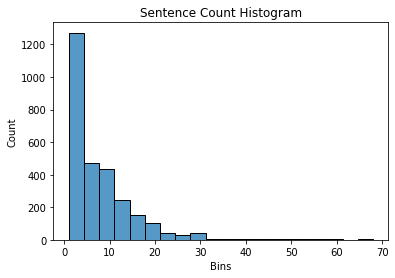

In [20]:
## SENTENCE COUNT VISUALIZATIONS

# Histogram object
sentence_hist = sns.histplot(data = sentences, x = sentences, bins = 20)
sentence_hist.set(xlabel = "Bins", ylabel = "Count", title="Sentence Count Histogram")

[Text(0.5, 0, 'Bins'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Word Count Histogram')]

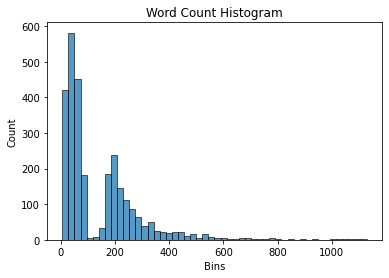

In [21]:
## WORD COUNT VISUALIZATIONS

# Histogram object
word_hist = sns.histplot(data = word_counts, x = word_counts, bins = 50)
word_hist.set(xlabel = "Bins", ylabel = "Count", title="Word Count Histogram")


[Text(0.5, 0, 'Bins'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Character Count Histogram')]

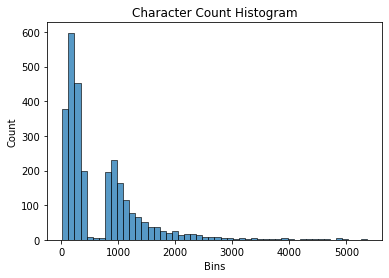

In [22]:
## CHARACTER COUNT VISUALIZATIONS

# Histogram object
char_hist = sns.histplot(data = char_counts, x = char_counts, bins = 50)
char_hist.set(xlabel = "Bins", ylabel = "Count", title = "Character Count Histogram")

The distributions above have a marked bimodality. Before removing outliers, it would be best to make a few additional calculations and try to determine more details about the distributions.

First, average sentence and word lengths should be calculated.

In [23]:
# Average sentence lengths
eng_revs['avg_sentence_length'] = eng_revs['word_counts']/eng_revs['sentence_counts']

# Average word lengths
eng_revs['avg_word_length'] = eng_revs['char_counts']/eng_revs['word_counts']

eng_revs.head(5)

,grade,user_name,text,date,language,sentence_counts,word_counts,char_counts,avg_sentence_length,avg_word_length
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en,6,84,381,14.000000,4.535714
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en,9,188,927,20.888889,4.930851
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20,en,9,207,1000,23.000000,4.830918
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20,en,3,63,277,21.000000,4.396825
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20,en,10,211,979,21.100000,4.639810


[Text(0.5, 0, 'Bins'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Avg. Sentence Length Histogram')]

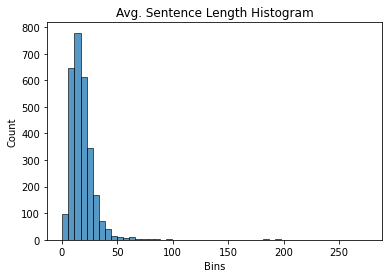

In [24]:
## AVG SENTENCE LENGTH VISUALIZATIONS

# Histogram object
avg_s_hist = sns.histplot(data = eng_revs, x = eng_revs.avg_sentence_length, bins = 50)
avg_s_hist.set(xlabel = "Bins", ylabel = "Count", title = "Avg. Sentence Length Histogram")

[Text(0.5, 0, 'Bins'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Avg. Word Length Histogram')]

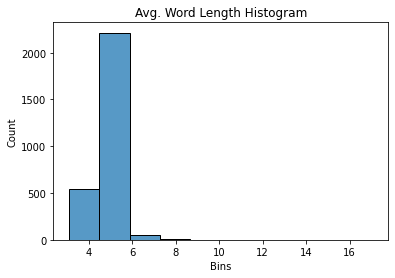

In [25]:
## AVG WORD LENGTH VISUALIZATIONS

# Histogram object
avg_w_hist = sns.histplot(data = eng_revs, x = eng_revs.avg_word_length, bins = 10)
avg_w_hist.set(xlabel = "Bins", ylabel = "Count", title = "Avg. Word Length Histogram")

In [26]:
# Ranges of average word counts
min_avg_wc = min(eng_revs.avg_word_length)
max_avg_wc = max(eng_revs.avg_word_length)

F'The smallest avg word length is {min_avg_wc}, and the largest is {max_avg_wc}.'


'The smallest avg word length is 3.076923076923077, and the largest is 17.071428571428573.'

### Text Analysis: Groupings Derived from Ratings

In general, text analysis tries to derive information from texts so that further data analysis can be conducted. This differs from text analytics, in that text analytics employs natural language processing methods to obtained meaning from unstructured text data (sentiment analysis, topic modeling, etc).

One way to move forward with text analysis that happens within UX research is categorizing text data according to associated ratings. For example, if a respondent is asked to rate their satisfaction on a 1 to 5 scale and then provides additional detail in an open-ended follow up question, you could classify their response as either negative, neutral, or positive based on the associated rating. I will show that below using the reviews dataframe.

__Valence Groupings__
- Negative: 0 thru 3
- Neutral: 4 thru 6
- Positive: 7 thru 10

Since the rating scale seen in reviews is ordinal, data loss by collapsing into 3 categories is less of a concern. In some instances, collapsing ordinal data can help balance out skewed data. We will see if this happens in our data shortly.

In [27]:
# Add a new column to reviews_df to hold the rating category
eng_revs['category'] = ['negative' if r in grade_categories['negative'] else 'neutral' if r in grade_categories['neutral'] else 'positive' if r in grade_categories['positive'] else 'invalid' for r in eng_revs.grade]

In [28]:
eng_revs.head(5)

,grade,user_name,text,date,language,sentence_counts,word_counts,char_counts,avg_sentence_length,avg_word_length,category
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en,6,84,381,14.000000,4.535714,neutral
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en,9,188,927,20.888889,4.930851,neutral
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20,en,9,207,1000,23.000000,4.830918,negative
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20,en,3,63,277,21.000000,4.396825,negative
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20,en,10,211,979,21.100000,4.639810,negative


In [29]:
# Create a table displaying word counts by category
valence_table = tabulate({'Valence Group': ['Negative', 'Neutral', 'Positive'],
                     'Counts per Group': [len([i for i in eng_revs.category if i == 'negative']),
                                len([i for i in eng_revs.category if i == 'neutral']),
                                len([i for i in eng_revs.category if i == 'positive'])]},
                      headers = 'keys', 
                      tablefmt = 'fancy_grid')

# Display the table
print(valence_table)

╒═════════════════╤════════════════════╕
│ Valence Group   │   Counts per Group │
╞═════════════════╪════════════════════╡
│ Negative        │               1591 │
├─────────────────┼────────────────────┤
│ Neutral         │                218 │
├─────────────────┼────────────────────┤
│ Positive        │               1019 │
╘═════════════════╧════════════════════╛


### Ranges per Valence Category

In [30]:
# Sentence count ranges
# Negative
s_neg_max = eng_revs.sentence_counts[eng_revs.category == 'negative'].max()
s_neg_min = eng_revs.sentence_counts[eng_revs.category == 'negative'].min()
s_neg_avg = eng_revs.sentence_counts[eng_revs.category == 'negative'].mean()
s_neg_stdev = eng_revs.sentence_counts[eng_revs.category == 'negative'].std()

# Neutral
s_ntl_max = eng_revs.sentence_counts[eng_revs.category == 'neutral'].max()
s_ntl_min = eng_revs.sentence_counts[eng_revs.category == 'neutral'].min()
s_ntl_avg = eng_revs.sentence_counts[eng_revs.category == 'neutral'].mean()
s_ntl_stdev = eng_revs.sentence_counts[eng_revs.category == 'neutral'].std()

# Positive
s_pos_max = eng_revs.sentence_counts[eng_revs.category == 'positive'].max()
s_pos_min = eng_revs.sentence_counts[eng_revs.category == 'positive'].min()
s_pos_avg = eng_revs.sentence_counts[eng_revs.category == 'positive'].mean()
s_pos_stdev = eng_revs.sentence_counts[eng_revs.category == 'positive'].std()


# Word count ranges
# Negative
wc_neg_max = eng_revs.word_counts[eng_revs.category == 'negative'].max()
wc_neg_min = eng_revs.word_counts[eng_revs.category == 'negative'].min()
wc_neg_avg = eng_revs.word_counts[eng_revs.category == 'negative'].mean()
wc_neg_stdev = eng_revs.word_counts[eng_revs.category == 'negative'].std()

# Neutral
wc_ntl_max = eng_revs.word_counts[eng_revs.category == 'neutral'].max()
wc_ntl_min = eng_revs.word_counts[eng_revs.category == 'neutral'].min()
wc_ntl_avg = eng_revs.word_counts[eng_revs.category == 'neutral'].mean()
wc_ntl_stdev = eng_revs.word_counts[eng_revs.category == 'neutral'].std()

# Positive
wc_pos_max = eng_revs.word_counts[eng_revs.category == 'positive'].max()
wc_pos_min = eng_revs.word_counts[eng_revs.category == 'positive'].min()
wc_pos_avg = eng_revs.word_counts[eng_revs.category == 'positive'].mean()
wc_pos_stdev = eng_revs.word_counts[eng_revs.category == 'positive'].std()

# Char count ranges
# Negative
char_neg_max = eng_revs.char_counts[eng_revs.category == 'negative'].max()
char_neg_min = eng_revs.char_counts[eng_revs.category == 'negative'].min()
char_neg_avg = eng_revs.char_counts[eng_revs.category == 'negative'].mean()
char_neg_stdev = eng_revs.char_counts[eng_revs.category == 'negative'].std()

# Neutral
char_ntl_max = eng_revs.char_counts[eng_revs.category == 'neutral'].max()
char_ntl_min = eng_revs.char_counts[eng_revs.category == 'neutral'].min()
char_ntl_avg = eng_revs.char_counts[eng_revs.category == 'neutral'].mean()
char_ntl_stdev = eng_revs.char_counts[eng_revs.category == 'neutral'].std()

# Positive
char_pos_max = eng_revs.char_counts[eng_revs.category == 'positive'].max()
char_pos_min = eng_revs.char_counts[eng_revs.category == 'positive'].min()
char_pos_avg = eng_revs.char_counts[eng_revs.category == 'positive'].mean()
char_pos_stdev = eng_revs.char_counts[eng_revs.category == 'positive'].std()

In [31]:
# Create tabular object
valence_stats = tabulate({'Valence Group': ['Negative', 'Neutral', 'Positive'],
                          'Max Sent Count': [s_neg_max, s_ntl_max, s_pos_max],
                          'Min Sent Count': [s_neg_min, s_ntl_min, s_pos_min],
                          'Avg Sentence Count': [s_neg_avg, s_ntl_avg, s_pos_avg],
                          'Std Dev Sent Count': [s_neg_stdev, s_ntl_stdev, s_pos_stdev],
                          'Max Word Count': [wc_neg_max, wc_ntl_max, wc_pos_max],
                          'Min Word Count': [wc_neg_min, wc_ntl_min, wc_pos_min],
                          'Avg Word Count': [wc_neg_avg, wc_ntl_avg, wc_pos_avg],
                          'Std Dev Word Count': [wc_neg_stdev, wc_ntl_stdev, wc_pos_stdev],
                          'Max Char Count': [char_neg_max, char_ntl_max, char_pos_max],
                          'Min Char Count': [char_neg_min, char_ntl_min, char_pos_min],
                          'Avg Char Count': [char_neg_avg, char_ntl_avg, char_pos_avg],
                          'Std Dev Char Count': [char_neg_stdev, char_ntl_stdev, char_pos_stdev]},
                          headers = 'keys', 
                          tablefmt = 'fancy_grid')

# Display
print(valence_stats)

╒═════════════════╤══════════════════╤══════════════════╤══════════════════════╤══════════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════════╕
│ Valence Group   │   Max Sent Count │   Min Sent Count │   Avg Sentence Count │   Std Dev Sent Count │   Max Word Count │   Min Word Count │   Avg Word Count │   Std Dev Word Count │   Max Char Count │   Min Char Count │   Avg Char Count │   Std Dev Char Count │
╞═════════════════╪══════════════════╪══════════════════╪══════════════════════╪══════════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════════╪══════════════════╪══════════════════╪══════════════════╪══════════════════════╡
│ Negative        │               59 │                1 │              8.06097 │              6.99843 │             1032 │                6 │          141.501 │              139.277 │             4931 │      

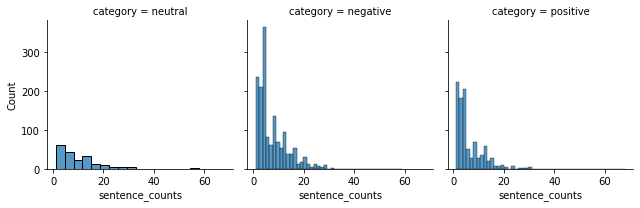

In [32]:
# Distribution of sentences by category
s_hist_facets = sns.FacetGrid(eng_revs, col = 'category')
s_hist_facets.map_dataframe(sns.histplot, x = 'sentence_counts')

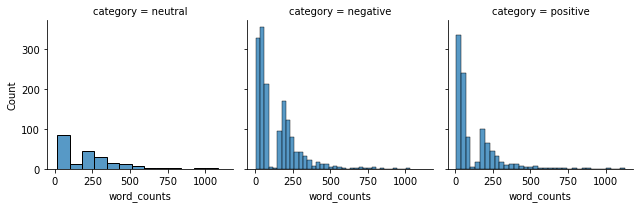

In [33]:
# Distributions of word counts by category
word_hist_facets = sns.FacetGrid(eng_revs, col = 'category')
word_hist_facets.map_dataframe(sns.histplot, x = 'word_counts')

Earlier I mentioned that sometimes collapsing across ordinal variable categories will improve the distribution of the data. As shown above, this did not happen. That means that simply parsing responses according to our 3 valences is not adequate. A different tactic will likely need to be taken, but first I will finish exploring the current enforced structure.

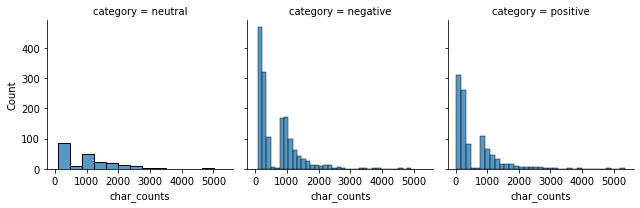

In [34]:
# Distributions of character counts by category
char_hist_facets = sns.FacetGrid(eng_revs, col = 'category')
char_hist_facets.map_dataframe(sns.histplot, x = 'char_counts')

[Text(0.5, 1.0, 'Sentence Counts by Rating Category'),
 Text(0.5, 0, 'Rating Category'),
 Text(0, 0.5, 'Sentence Counts')]

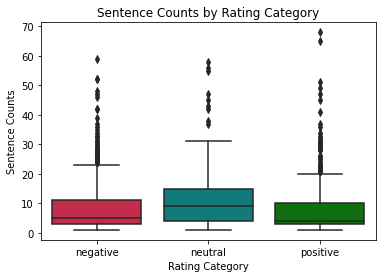

In [35]:
# Seaborn box plots of sentence counts by category

cat_palette = {'negative': 'crimson',
               'neutral': 'darkcyan',
               'positive': 'green'}

sc_boxes = sns.boxplot(x = 'category', 
                       y = 'sentence_counts', 
                       data = eng_revs, 
                       order = ['negative', 'neutral', 'positive'],
                       palette = cat_palette).set(title = 'Sentence Counts by Rating Category',
                                                                        xlabel = 'Rating Category',
                                                                        ylabel = 'Sentence Counts')

sc_boxes

[Text(0.5, 1.0, 'Word Counts by Rating Category'),
 Text(0.5, 0, 'Rating Category'),
 Text(0, 0.5, 'Word Counts')]

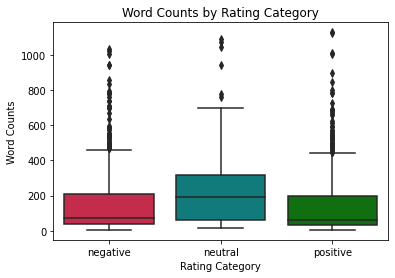

In [36]:
# Seaborn box plots of word counts by category

wc_boxes = sns.boxplot(x = 'category', 
                       y = 'word_counts', 
                       data = eng_revs, 
                       order = ['negative', 'neutral', 'positive'],
                       palette = cat_palette).set(title = 'Word Counts by Rating Category',
                                                                        xlabel = 'Rating Category',
                                                                        ylabel = 'Word Counts')

wc_boxes

There are a lot of outliers across all three categories. Again, this reinforces that simply collapsing the responses into 3 categories and using that to guide an analysis of review text is inadequate. 

[Text(0.5, 1.0, 'Character Counts by Rating Category'),
 Text(0.5, 0, 'Rating Category'),
 Text(0, 0.5, 'Character Counts')]

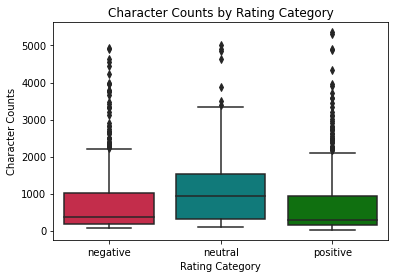

In [37]:
# Seaborn box plots of character counts by category
char_boxes = sns.boxplot(x = 'category', 
                         y = 'char_counts', 
                         data = eng_revs, 
                         order = ['negative', 'neutral', 'positive'],
                         palette = cat_palette).set(title = 'Character Counts by Rating Category',
                                                                        xlabel = 'Rating Category',
                                                                        ylabel = 'Character Counts')

char_boxes

What would be interesting to understand, based on the features of the comments, is if some sort of grouping exists that is not being picked up on based on rating and comment length in word count and character count. 
- Is there a distinct group of reviewers that gives shorter reviews versus longer reviews?

To start, let's look at a plot of ratings versus the various lengths.

<AxesSubplot:xlabel='grade', ylabel='sentence_counts'>

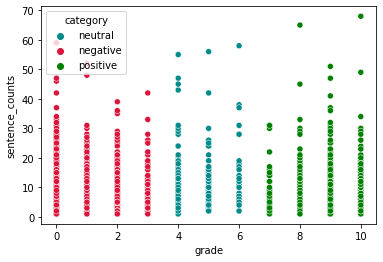

In [38]:
# Create the scatter plot object
s_scatter = sns.scatterplot(x = 'grade', y = 'sentence_counts', data = eng_revs, hue = 'category', palette = cat_palette)

# Display the scatter plot
s_scatter

<AxesSubplot:xlabel='grade', ylabel='word_counts'>

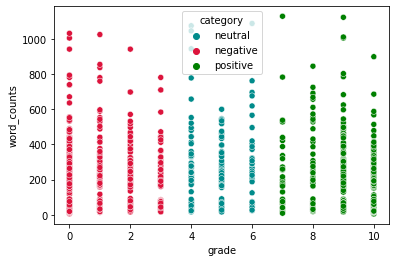

In [39]:
# Create the scatter plot object
word_scatter = sns.scatterplot(x = 'grade', y = 'word_counts', data = eng_revs, hue = 'category', palette = cat_palette)

# Display the scatter plot
word_scatter

<AxesSubplot:xlabel='grade', ylabel='char_counts'>

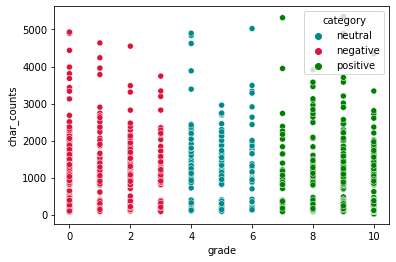

In [40]:
# Create the character scatter plot object
char_scatter = sns.scatterplot(x = 'grade', y = 'char_counts', data = eng_revs, hue = 'category', palette = cat_palette)

# Display the scatter plot
char_scatter

All of the scatter plots appear to show the data breaking out into multiple groups. This is especially noticeable in the word and character count scatter plots, in which both show a lot of breaks in the distribution of points at ratings 6 through 8. Although in my scatter plots I fitted groupings of neutral, negative, and positive based on the grade associated with the rating, I'm not confident that 3 groupings are actually enough to summarize the data. 

### Evaluating Bimodality in the Data

The word count and character count data shows potential bimodality. Digging into this further requires the use of a Gaussian Mixture Model as way to get at density estimation.


#### Transforming Data

Since both word and character count show a very positive skew along with bimodality, the data should undergo a transformation. The question is which transformation will give us the best result? That's where the Box Cox Transformation can be useful. The boxcox() function from scipy.stats will automatically apply the best transformation for a dataset.

The lambda value for transforms is -0.07612067991870959.


<Figure size 576x576 with 0 Axes>

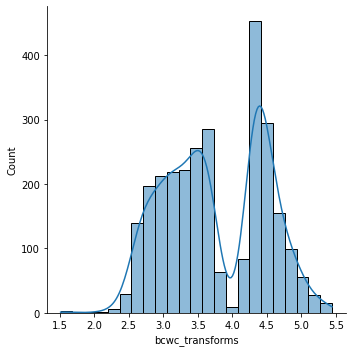

In [41]:
# Return transformed data in an array
eng_revs['bcwc_transforms'], bcwc_lambda = boxcox(eng_revs['word_counts'])
print(F'The lambda value for transforms is {bcwc_lambda}.')

# Visualization of transformed data
plt.figure(figsize = (8, 8))
sns.displot(eng_revs['bcwc_transforms'], kde = True)
plt.show()

From the above transformation, there is definite bimodality in the distribution of review length defined by word count.

In [42]:
# Check the dataframe
eng_revs.head(5)

,grade,user_name,text,date,language,sentence_counts,word_counts,char_counts,avg_sentence_length,avg_word_length,category,bcwc_transforms
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en,6,84,381,14.000000,4.535714,neutral,3.760985
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en,9,188,927,20.888889,4.930851,neutral,4.318693
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20,en,9,207,1000,23.000000,4.830918,negative,4.383084
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20,en,3,63,277,21.000000,4.396825,negative,3.553398
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20,en,10,211,979,21.100000,4.639810,negative,4.395828


In [43]:
# Create a new dataframe of only the transformed word counts
reviews_bcwc = pd.DataFrame(eng_revs[['bcwc_transforms']])
reviews_bcwc.head(5)

,bcwc_transforms
0,3.760985
1,4.318693
2,4.383084
3,3.553398
4,4.395828


#### Determining the Number of Clusters: AIC vs BIC

AIC and BIC are metrics for judging groupings based on how closely the elements within each group hang together.

- __AIC, Akaike's Information Criteria__
    - Does not limit the number of parameters or models.
    - Helps judge model fit by estimating prediction error; the lower the better.
- __BIC, Bayesian Information Criteria__
    - Looks for fit amongst a finite number of models; the lower the better.
    - Does not perform well for non-normal data distributions.
    
With Gaussian models, you can't be sure that the data won't be elliptical (non-circular), so you can't use the typical silhouette width judgments. AIC and BIC, however, can be judged using the elbow method. There are some limitations, though. Normally, BIC is viewed as the best criteria for selecting the appropriate number of clusters, but that falls apart when distributions are not normally distributed. This will be discussed in more detail after showing a plot of both AIC and BIC.

In [44]:
# AIC
# Group range
groupings = range(2,9)

# Create a list to hold AIC values
aic = []
lowest_aic = np.infty

for g in groupings:
    # Fit a Gaussian mixture with EM
    test_a_gmm = GaussianMixture(n_components=g,covariance_type= 'full')
    test_a_gmm.fit(reviews_bcwc)
    aic.append(test_a_gmm.aic(reviews_bcwc))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_a_gmm = test_a_gmm

In [45]:
# Create a list to hold AIC values
bic = []
lowest_bic = np.infty

for g in groupings:
    # Fit a Gaussian mixture with EM
    test_b_gmm = GaussianMixture(n_components=g, covariance_type= 'full')
    test_b_gmm.fit(reviews_bcwc)
    bic.append(test_b_gmm.bic(reviews_bcwc))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_b_gmm = test_b_gmm

In [46]:
# Tabular display of AIC and BIC values
aic_bic_tbl = tabulate({'k': [2, 3, 4, 5, 6, 7, 8],
                        'AIC': aic,
                        'BIC': bic},
                       headers = 'keys',
                       tablefmt = 'fancy_grid')
# Display table
print(aic_bic_tbl)

╒═════╤═════════╤═════════╕
│   k │     AIC │     BIC │
╞═════╪═════════╪═════════╡
│   2 │ 5361.17 │ 5390.91 │
├─────┼─────────┼─────────┤
│   3 │ 5195.44 │ 5243.02 │
├─────┼─────────┼─────────┤
│   4 │ 4847.4  │ 5212.21 │
├─────┼─────────┼─────────┤
│   5 │ 4818.49 │ 4903.22 │
├─────┼─────────┼─────────┤
│   6 │ 4819.81 │ 4895.87 │
├─────┼─────────┼─────────┤
│   7 │ 4793.98 │ 4874.83 │
├─────┼─────────┼─────────┤
│   8 │ 4738.94 │ 4863.36 │
╘═════╧═════════╧═════════╛


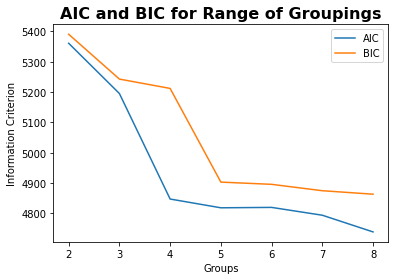

In [47]:
# Visualizations
x1 = groupings
y1 = aic
plt.plot(x1, y1, label = "AIC")
x2 = groupings
y2 = bic
plt.plot(x2, y2, label = "BIC")

plt.title("AIC and BIC for Range of Groupings", fontsize=16, fontweight='bold')
plt.xlabel("Groups")
plt.ylabel("Information Criterion")
plt.legend(loc='upper right')
plt.show()


The steepest drop for both AIC and BIC starts at a value of 2 and continues until 4 for AIC and 5 for BIC. This suggest that there is more than just bimodality happening in our data. 

For this scenario, let's pursue k = 4 as advised by AIC.

Initialization 0
Initialization converged: True


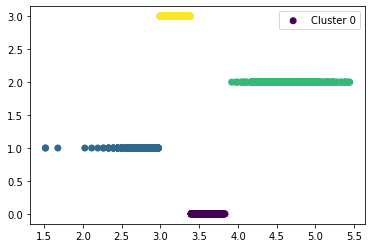

In [48]:
# Following through with the 4 component model
bcwc_gmm = GaussianMixture(n_components= 4, random_state = 42, verbose = 1) # Initialize the model with details
bcwc_model = bcwc_gmm.fit(reviews_bcwc) # Fit the model

# Predictions from gmm
bcwc_labels = bcwc_gmm.predict(reviews_bcwc) # The labels
bcwc_frame = pd.DataFrame(reviews_bcwc) # Create a dataframe
bcwc_frame['cluster'] = bcwc_labels # Add a column to the dataframe

set_bcwc_labels = set(bcwc_labels)

# Charting colors
colors = ['red', 'blue']
data = bcwc_frame
plt.scatter(data.iloc[:,0],data.iloc[:,1],c=bcwc_labels, cmap='viridis')
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.show()

The clustering observed above is pretty clean, indicating that there are indeed two separate distributions. 

In [49]:
# Print model summary
bcwc_model_table = tabulate({'k = 4 Model Means': bcwc_model.means_},
                            headers = 'keys', 
                            tablefmt = 'fancy_grid')

print(bcwc_model_table)
print('Converged: ', bcwc_model.converged_)
print('No. of Iterations: ', bcwc_model.n_iter_)

╒═════════════════════╕
│   k = 4 Model Means │
╞═════════════════════╡
│             3.57945 │
├─────────────────────┤
│             2.77465 │
├─────────────────────┤
│             4.51002 │
├─────────────────────┤
│             3.18554 │
╘═════════════════════╛
Converged:  True
No. of Iterations:  5


### Understanding the Clusters
Since there are 4 clusters, it's worth understanding what makes them unique. To fully accomplish that, first join the cluster labels back to the dataframe containing all of the data leading up to the cluster analysis.

In [50]:
# Create a new column for clusters
eng_revs['cluster'] = bcwc_labels

# Preview the new dataframe
eng_revs.head(5)

,grade,user_name,text,date,language,sentence_counts,word_counts,char_counts,avg_sentence_length,avg_word_length,category,bcwc_transforms,cluster
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en,6,84,381,14.000000,4.535714,neutral,3.760985,0
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en,9,188,927,20.888889,4.930851,neutral,4.318693,2
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20,en,9,207,1000,23.000000,4.830918,negative,4.383084,2
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20,en,3,63,277,21.000000,4.396825,negative,3.553398,0
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20,en,10,211,979,21.100000,4.639810,negative,4.395828,2


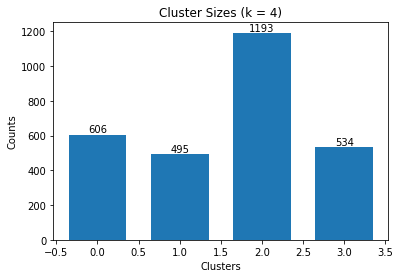

In [51]:
# Cluster sizes
bcwc_cluster_sizes = Counter(eng_revs.cluster)

# Clusters
cluster = []
# Counts
counts = []

# Split back into cluster and counts
for i in sorted(bcwc_cluster_sizes.items()):
    cluster.append(i[0])
    counts.append(i[1])

# Bar chart
cluster_bars = plt.bar(cluster, counts, width = 0.7)

# Add annotation to bars
plt.bar_label(cluster_bars)

# Chart labels
plt.xlabel("Clusters")
plt.ylabel("Counts")
plt.title("Cluster Sizes (k = 4)")
plt.show()

These groups are not nearly equal in size. This is not ideal, but not wholly unexpected, either. 

#### Cluster 0 Details

In [52]:
# Group by clusters
grouped_eng_revs = eng_revs.groupby('cluster')

# Preview the grouping by first of every cluster
grouped_eng_revs.first()

,grade,user_name,text,date,language,sentence_counts,word_counts,char_counts,avg_sentence_length,avg_word_length,category,bcwc_transforms
cluster,,,,,,,,,,,,
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en,6,84,381,14.000000,4.535714,neutral,3.760985
1,0,RocketRon,This is so annoying. Only one player has the a...,2020-03-20,en,4,28,138,7.000000,4.928571,negative,2.943174
2,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en,9,188,927,20.888889,4.930851,neutral,4.318693
3,0,Gravy_Dreamboat,You can only have one island per Switch. If mu...,2020-03-20,en,4,38,181,9.500000,4.763158,negative,3.177406


In [53]:
# Create dataframes based on each cluster for ease
# Get Cluster 0
cluster0_df = grouped_eng_revs.get_group(0)
# Get Cluster 1
cluster1_df = grouped_eng_revs.get_group(1)
# Get Cluster 2
cluster2_df=grouped_eng_revs.get_group(2)
# Get Cluster 3
cluster3_df=grouped_eng_revs.get_group(3)

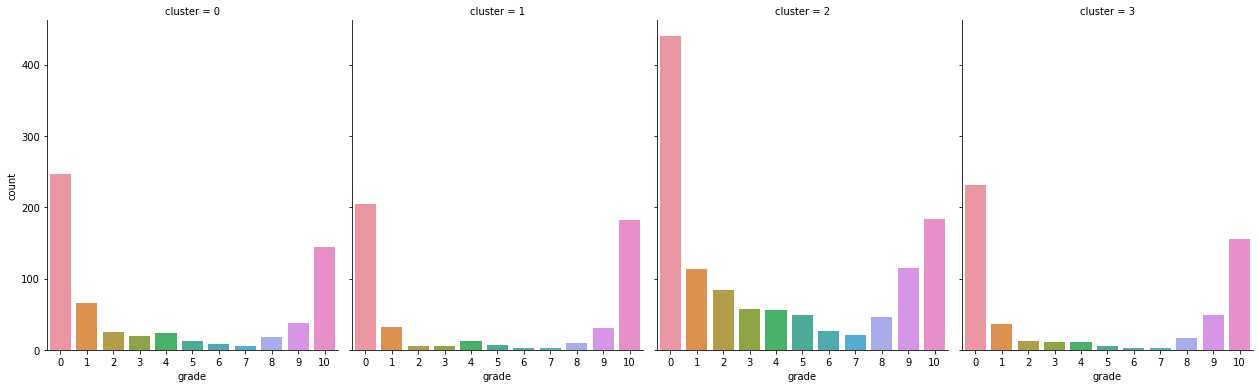

In [54]:
# Distributions of grades by cluster
cluster_grade_facets = sns.catplot(x="grade", 
                                   col="cluster", 
                                   col_wrap=4,
                                   data=eng_revs, 
                                   kind="count", 
                                   height=5.5, 
                                   aspect=.8)

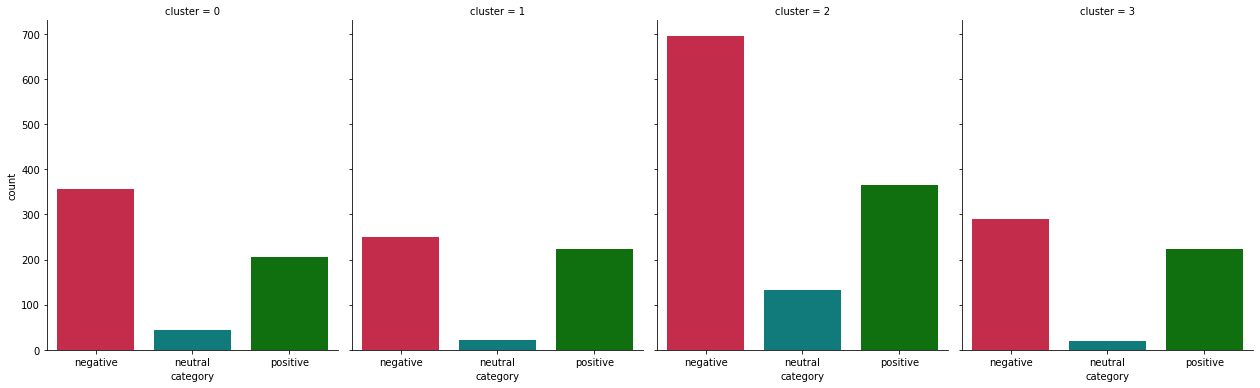

In [55]:
# Distribution of Category by Cluster
cluster_category_facets = sns.catplot(x="category", 
                                      col="cluster", 
                                      col_wrap=4,
                                      data=eng_revs,
                                      order = ['negative', 'neutral', 'positive'],
                                      kind="count", 
                                      height=5.5, 
                                      aspect=.8,
                                      palette = cat_palette)

cluster_category_facets

In [56]:
# Sentence Counts
c0_sc_min = cluster0_df['sentence_counts'].min()
c0_sc_max = cluster0_df['sentence_counts'].max()
c0_sc_avg = cluster0_df['sentence_counts'].mean()
c0_sc_stdev = cluster0_df['sentence_counts'].std()

# Word Counts
c0_wc_min = cluster0_df['word_counts'].min()
c0_wc_max = cluster0_df['word_counts'].max()
c0_wc_avg = cluster0_df['word_counts'].mean()
c0_wc_stdev = cluster0_df['word_counts'].std()

# Character Counts
c0_cc_min = cluster0_df['char_counts'].min()
c0_cc_max = cluster0_df['char_counts'].max()
c0_cc_avg = cluster0_df['char_counts'].mean()
c0_cc_stdev = cluster0_df['char_counts'].std()

c0_counts_table = tabulate({'Item': ['Sentence', 'Word', 'Character'],
                            'Minimums': [c0_sc_min, c0_wc_min, c0_cc_min],
                            'Maximums': [c0_sc_max, c0_wc_max, c0_cc_max],
                            'Averages': [c0_sc_avg, c0_wc_avg, c0_cc_avg],
                            'Standard Deviations': [c0_sc_stdev, c0_wc_stdev, c0_cc_stdev]},
                            headers = 'keys',
                            tablefmt = 'fancy grid')

# View table
print(c0_counts_table)

Item         Minimums    Maximums    Averages    Standard Deviations
---------  ----------  ----------  ----------  ---------------------
Sentence            1          30     4.79538                2.59708
Word               51          93    66.9274                10.1906
Character         197         594   317.873                 53.3501


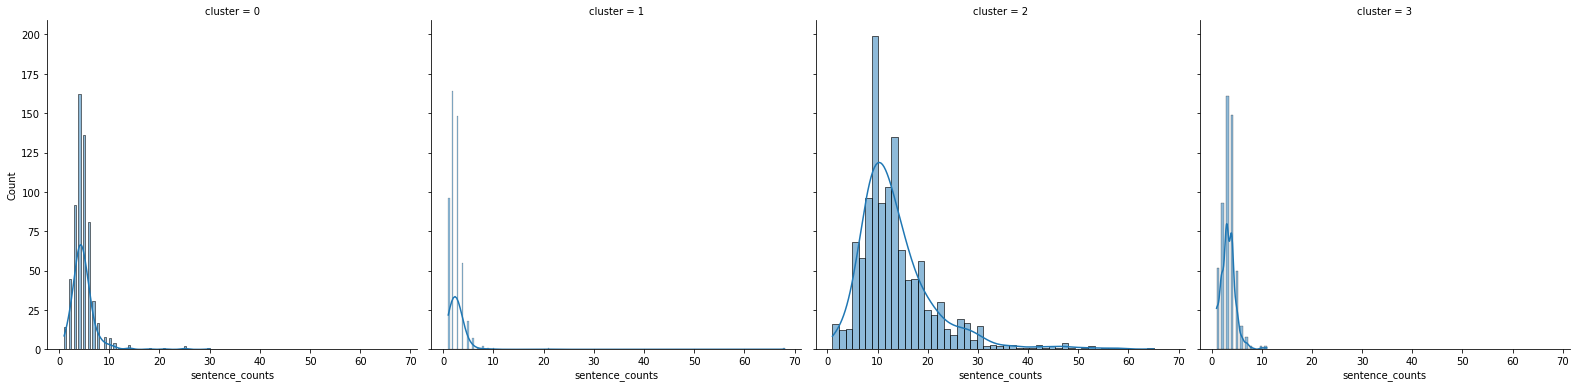

In [57]:
# Cluster sentence count histograms comparison
cluster_sent_facets = sns.FacetGrid(eng_revs, col = 'cluster', col_wrap = 4, height = 5.5)
cluster_sent_facets.map_dataframe(sns.histplot, x = 'sentence_counts', kde = True)

cluster_sent_facets

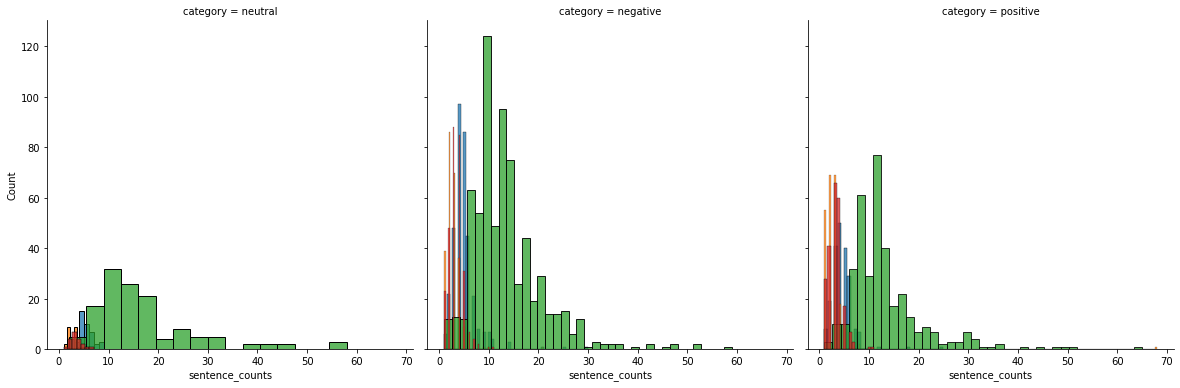

In [58]:
# Cluster sentence counts by valence grouping
cluster_vs_facets = sns.FacetGrid(eng_revs, col = 'category', hue = 'cluster', height = 5.5)
cluster_vs_facets.map_dataframe(sns.histplot, x = 'sentence_counts')

cluster_vs_facets

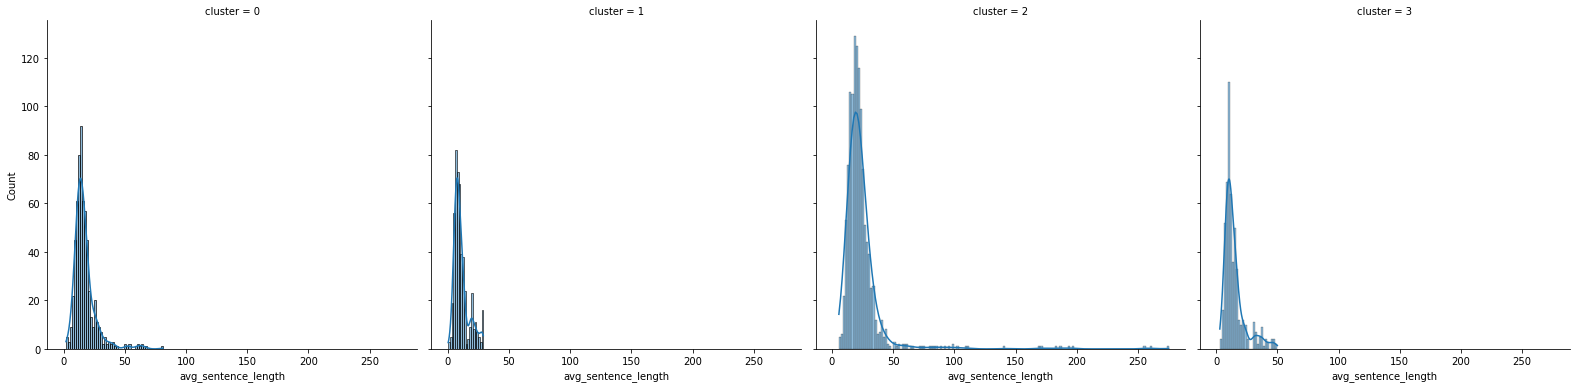

In [59]:
# Cluster sentence count histograms comparison
cluster_avgsent_facets = sns.FacetGrid(eng_revs, col = 'cluster', col_wrap = 4, height = 5.5)
cluster_avgsent_facets.map_dataframe(sns.histplot, x = 'avg_sentence_length', kde = True)

cluster_avgsent_facets

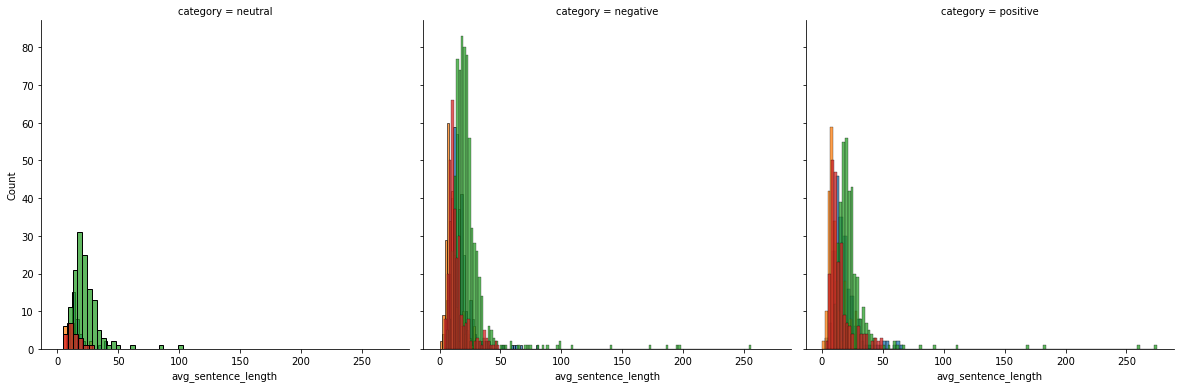

In [60]:
# Cluster avg sentence lengths by valence grouping
cluster_vavgs_facets = sns.FacetGrid(eng_revs, col = 'category', hue = 'cluster', height = 5.5)
cluster_vavgs_facets.map_dataframe(sns.histplot, x = 'avg_sentence_length')

cluster_vavgs_facets

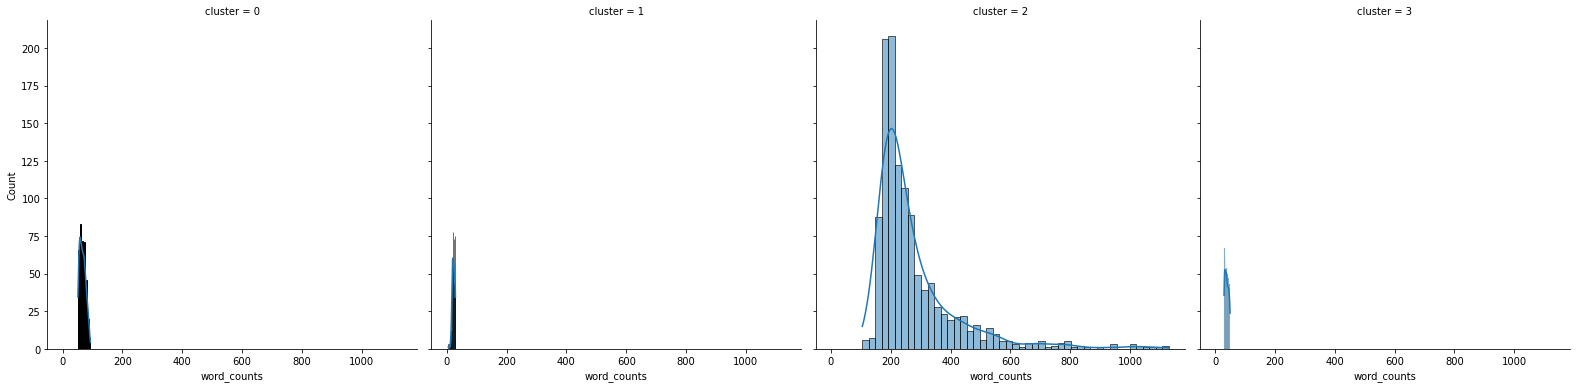

In [61]:
# Cluster word count histograms
cluster_wc_facets = sns.FacetGrid(eng_revs, col = 'cluster', col_wrap = 4, height = 5.5)
cluster_wc_facets.map_dataframe(sns.histplot, x = 'word_counts', kde = True)

cluster_wc_facets

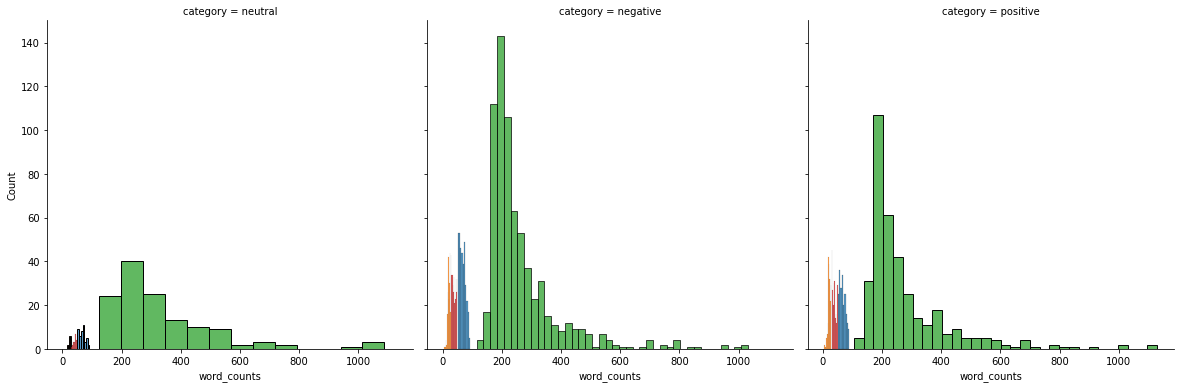

In [62]:
# Cluster word counts by valence grouping
cluster_wcs_facets = sns.FacetGrid(eng_revs, col = 'category', hue = 'cluster', height = 5.5)
cluster_wcs_facets.map_dataframe(sns.histplot, x = 'word_counts')

cluster_wcs_facets

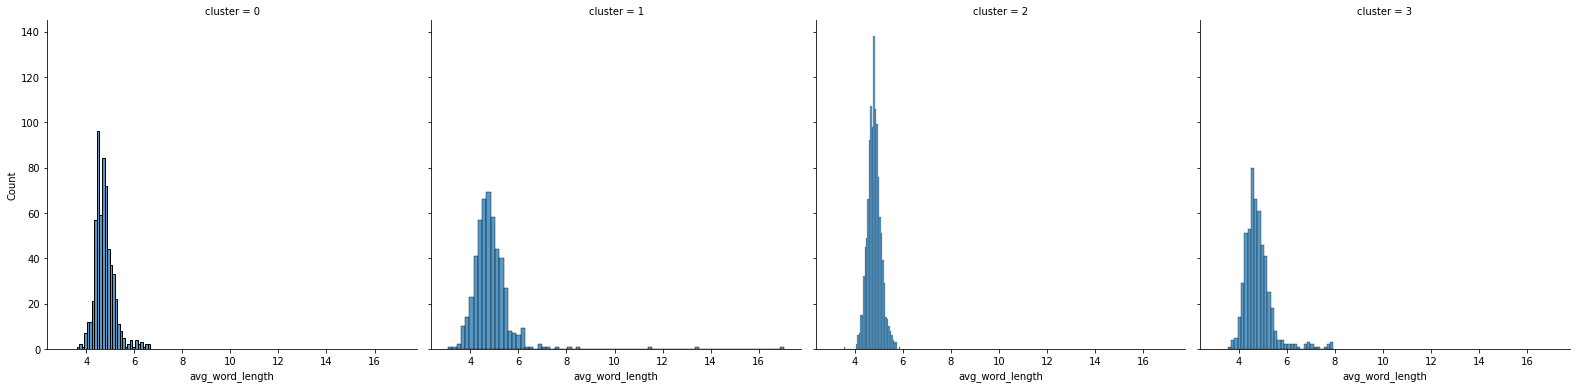

In [63]:
# Cluster average word length histogram
cluster_avgwc_facets = sns.FacetGrid(eng_revs, col = 'cluster', col_wrap = 4, height = 5.5)
cluster_avgwc_facets.map_dataframe(sns.histplot, x = 'avg_word_length')

cluster_avgwc_facets

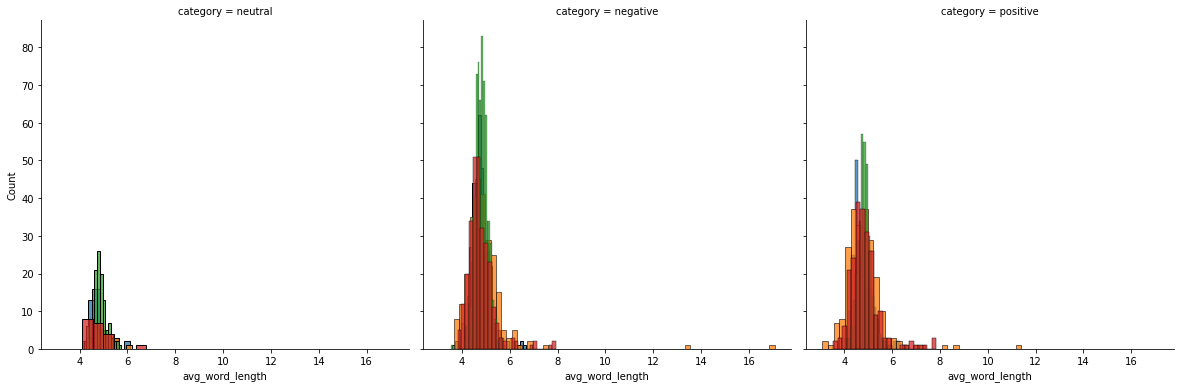

In [64]:
# Cluster avg word lengths by valence grouping
cluster_vavgw_facets = sns.FacetGrid(eng_revs, col = 'category', hue = 'cluster', height = 5.5)
cluster_vavgw_facets.map_dataframe(sns.histplot, x = 'avg_word_length')

cluster_vavgw_facets

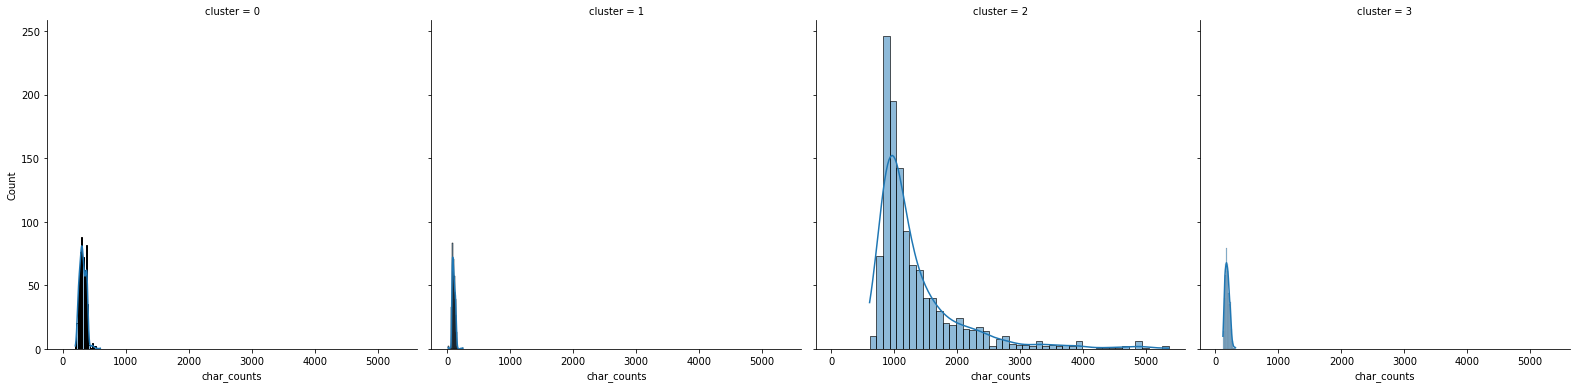

In [65]:
# Cluster character count histogram
cluster_cc_facets = sns.FacetGrid(eng_revs, col = 'cluster', col_wrap = 4, height = 5.5)
cluster_cc_facets.map_dataframe(sns.histplot, x = 'char_counts', kde = True)

cluster_cc_facets

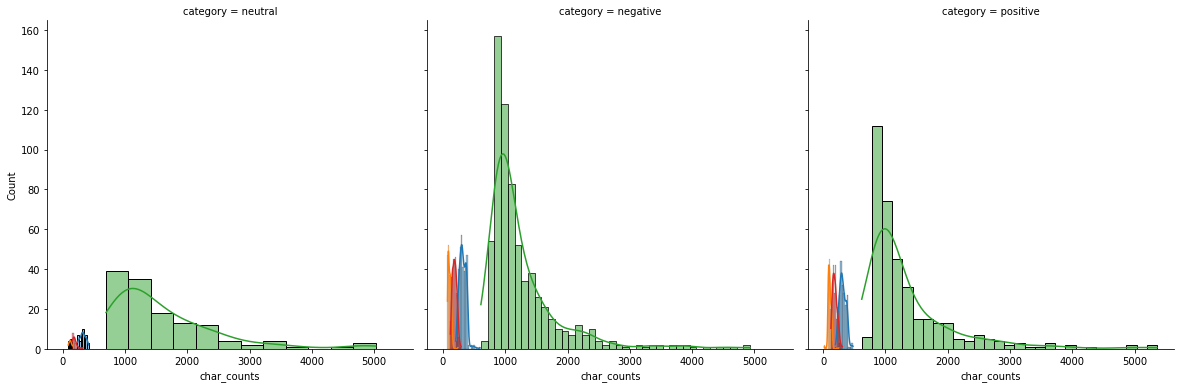

In [66]:
# Cluster char counts by valence grouping
cluster_vc_facets = sns.FacetGrid(eng_revs, col = 'category', hue = 'cluster', height = 5.5)
cluster_vc_facets.map_dataframe(sns.histplot, x = 'char_counts', kde = True)

cluster_vc_facets

Each of the graphs show distinct differences between the clusters. 

# Next Steps

This analysis looked at some easily accessible quantitative data about user reviews. The next steps for this data include further investigations of the linguistic features of English-language reviews.

In [67]:
# Output the clustered data to CSV
eng_revs.to_csv('cluster_acnh_reviews.csv', index = False)
